# Smart insole activity modelling

In this notebook we analyse some time series data taken from the sensors on the insole and attempt to fit a predictive model to determine what kind of activity is being performed.

## Overview
### The data

The [../data](data) consists of timestamped sensor readings from the device. Timestamps are in ISO-8601 datetime format and sensor readings are integer values representing pressure (force) in kg. Every second the device logs a reading from all of its sensors.

Example: `2019-11-18T10:00:00.001,10,15,11,25`

Which is `10 kg`, `15 kg`, `11 kg` and `25 kg` from sensors 1-4 respectively, at timestamp `2019-11-18T10:00:00.001`.

### Analysis

We begin by developing some general techniques for locating trends, correlations and periodicity in the sensor data, and this will lead us to make appropriate modelling choices. We also want to uncover statistical distributions in the data which will enable us to generate fake data that looks similar; fake data is useful for integration testing.

In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

# Data loading and cleaning

We load the data as a timeseries by specifying the first column as the index and parsing it as a date/time.

In [192]:
pressure_data = pd  \
    .read_csv("../data/sample.csv", index_col=0, parse_dates=[0]) \
    .query('date != "NaT"')

# Data exploration

In [193]:
pressure_data.dtypes

p1    int64
p2    int64
p3    int64
p4    int64
dtype: object

In [194]:
pressure_data.head()

,p1,p2,p3,p4
date,,,,
2020-08-14 10:00:00,0,0,0,0
2020-08-14 10:00:01,10,0,0,0
2020-08-14 10:00:02,20,5,3,0
2020-08-14 10:00:03,30,10,6,0
2020-08-14 10:00:04,10,15,9,0


## Plot all pressure sensor readings

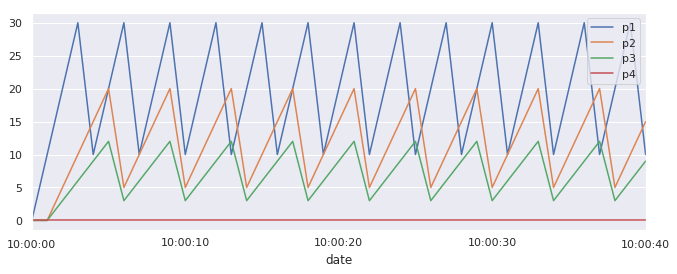

In [195]:
pressure_data.plot()

## Count steps

First, the naïve method for counting steps is based on looking for peaks in one of the sensors.

In [196]:
def count_steps_naive(dataframe):
    column = "p1"
    target_pressure = max(dataframe[column])
    return dataframe[dataframe[column] == target_pressure][column] \
        .count()

count_steps_naive(pressure_data)

13

A better approach can be found in this paper: https://ieeexplore.ieee.org/document/7405425

We need the average pressure as well as the rate of change in average pressure.

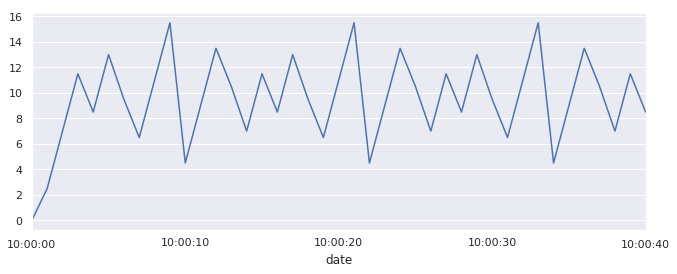

In [197]:
p_avg = pressure_data.mean(axis=1)
p_avg.plot()

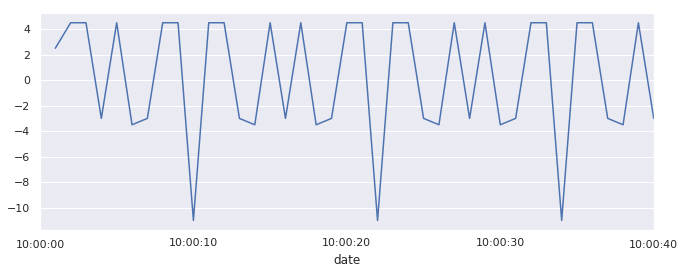

In [198]:
p_diff = p_avg.diff()
p_diff.plot()

In [199]:
t_max = pressure_data.index.max()
pressure_data[pressure_data.index == t_max]

,p1,p2,p3,p4
date,,,,
2020-08-14 10:00:40,10,15,9,0


In [202]:
def count_steps(dataframe, low_threshold=0, high_threshold=4):
    p_avg = dataframe.mean(axis=1)
    p_diff = p_avg.diff()

    status = 0
    step_count = 0
    for p_diff_t in p_diff:
        if p_diff_t < low_threshold:
            if status == 1:
                step_count += 1
            status = -1
        elif p_diff_t > high_threshold:
            status = 1
    return step_count

count_steps(pressure_data)

13

## Count cadence

In [206]:
def calculate_cadence(dataframe):
    duration = (dataframe.index.max() - dataframe.index.min()).seconds
    return count_steps(dataframe) / duration

calculate_cadence(pressure_data)

0.325

In [205]:
(pressure_data.index.max() - pressure_data.index.min()).seconds

40